## Deep Learning Para Aplicações de Inteligência Artificial
### Fine-Tunin de um Modelo Transformer Para Classificação de Sentimento


In [97]:
# Imports
import math
import nltk
import spacy
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

Carregando os Dados de Texto

In [3]:
# Loading train data
dados_dsa_treino = pd.read_csv('dados_treino.txt', header = None, delimiter = ';')


In [4]:
# Loading test data
dados_dsa_teste = pd.read_csv('dados_teste.txt', header = None, delimiter = ';')

In [5]:
# Renaming
dados_dsa_teste = dados_dsa_teste.rename(columns = {0 : 'texto', 1 : 'sentimento'})
dados_dsa_treino = dados_dsa_treino.rename(columns  = {0: 'texto', 1 : 'sentimento'})

In [6]:
# Shape
print(dados_dsa_teste.shape)
# Sample
dados_dsa_treino.head()

(2000, 2)


,texto,sentimento
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [7]:
# Shape
print(dados_dsa_treino.shape)
# Sample
dados_dsa_teste.head()

(16000, 2)


,texto,sentimento
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [8]:
# Sentiment count train data
dados_dsa_treino['sentimento'].value_counts()

sentimento
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [9]:
# Sentiment count test data
dados_dsa_teste['sentimento'].value_counts()

sentimento
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

### Pré- processamento dos dados
https://spacy.io

In [11]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [12]:
# Carrega o dicionário
dsa_nlp = spacy.load('en_core_web_md')

In [13]:
# Create a function that receives a text as parameter
def das_preprocessa_text(text):

    #Preprocess the text using a dictionaty
    doc = dsa_nlp(text)

    # Create a list with tokens in lower case and without white spaces and stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Return preprocessed tokens as a unique line, joining by white spaces
    return ' '.join(tokens)

In [14]:
# Applying the function to train data
dados_dsa_treino['texto_preprocessado'] = dados_dsa_treino['texto'].apply(das_preprocessa_text)

In [15]:
# Applying the function to test data
dados_dsa_teste['texto_preprocessado'] = dados_dsa_teste['texto'].apply(das_preprocessa_text)

In [16]:
# Sample
dados_dsa_treino.head()

,texto,sentimento,texto_preprocessado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


Version 1 - Fully Connected Neural Network Arquiteture


Step1: Using TF-IDF to vetorize

In [20]:
# Vectorization
dsa_tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [58]:
# Apply vetorizarion
dados_treino_tfidf = dsa_tfidf.fit_transform(dados_dsa_treino['texto_preprocessado'])
dados_teste_tfidf = dsa_tfidf.transform(dados_dsa_teste['texto_preprocessado'])

In [59]:
dados_treino_tfidf.shape

(16000, 5587)

In [60]:
dados_teste_tfidf.shape

(2000, 5587)

In [61]:
type(dados_treino_tfidf)

scipy.sparse._csr.csr_matrix

In [62]:
# converting data entry to array
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()

Step 2: Preparing the data  
We need to  convert the target feature to a numeric representation. We are going to use Label Encoding

In [63]:
# Creating Label encoder
dsa_le = LabelEncoder()

In [64]:
# Fit and transform the target feature in train and test
y_treino_le = dsa_le.fit_transform(dados_dsa_treino['sentimento'])
y_teste_le = dsa_le.transform(dados_dsa_teste['sentimento'])

In [65]:
# Class weigth
pesos_classes = compute_class_weight('balanced', classes = np.unique(y_treino_le), y = y_treino_le)

In [66]:
# Spliting the data in train and test (validation)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array,
                                                   y_treino_le,
                                                   test_size=  0.2,
                                                   random_state= 42,
                                                   stratify= y_treino_le)

In [80]:
# Identify the target feature as categoric
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_teste_le)
y_val_encoded = to_categorical(y_val)


In [81]:
# Shape
y_treino_encoded.shape, y_teste_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

In [79]:
X_treino.shape, X_teste_array.shape, X_val.shape

((12800, 5587), (2000, 5587), (3200, 5587))

Step 3: Creating the model

In [82]:
# Inicialize a sequential model. Sequential model are a linear stack of layers
modelo_dsa_v1 = Sequential()

# Add the first dense layer (fully-connected) to the model
modelo_dsa_v1.add(Dense(4096,
                        # Uzing SELU function (Scaled Exponential Linear Unit)
                        activation= 'selu',

                        # Initialize weights with LeCun normal distribution
                        kernel_initializer = 'lecun_normal',

                        # Define the entry formt based on X_treino features number
                        input_shape = (X_treino.shape[1],),

                        # Apply L2 regularization to reduce overfitting
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)
                         
                         ))

# Add second dense layer
modelo_dsa_v1.add(Dense(2048,
                        activation = 'selu',
                        kernel_initializer= 'lecun_normal',
                        kernel_regularizer= tf.keras.regularizers.l2(0.01) ))

# Add third dense layer
modelo_dsa_v1.add(Dense(1024,
                        activation= 'selu',
                        kernel_initializer= 'lecun_normal',
                        kernel_regularizer= tf.keras.regularizers.l2(0.1)))

# Add the forth dense layer
# Layer with 64 neuron and SELU activation
modelo_dsa_v1.add(Dense( 64, activation= 'selu'))

# Add the output layer
# layer with 6 neurons and softmax ativation to multiclass classification
modelo_dsa_v1.add(Dense(6, activation= 'softmax'))


c:\Users\erika\anaconda3\envs\sentimento\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 4: Model compilation and summary

In [83]:
# Assigning specific weight to the bias vector for the last layer
modelo_dsa_v1.layers[-1].bias.assign(pesos_classes)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [84]:
# Model compilation  
modelo_dsa_v1.compile(optimizer = 'Adam',
                      loss = tf.losses.categorical_crossentropy,
                      metrics = ['accuracy'])

In [85]:
modelo_dsa_v1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 4096)           │    22,888,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,443,270 (127.58 MB)

 Trainable params: 33,443,270 (127.58 MB)

 Non-trainable params: 0 (0.00 B)

Step 5: Callbacks and Early Stopping

In [86]:
# Function to the parameters on the learning rate scheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate 



In [87]:
# Learnign rate Scheduler
lr_scheduler = LearningRateScheduler(step_decay)

In [88]:
# Early stopping
early_stopping= EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience= 3)

Step 6: Train the model

In [89]:
# hypermarameters
num_epochs = 20
tamanho_batch = 256

In [90]:
%%time
history = modelo_dsa_v1.fit( X_treino,
                            y_treino_encoded,
                            validation_data = (X_val, y_val_encoded),
                            epochs = num_epochs,
                            batch_size = tamanho_batch,
                            callbacks = [early_stopping, lr_scheduler]
                            )

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.4803 - loss: 77.7735 - val_accuracy: 0.7513 - val_loss: 2.2694 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.8037 - loss: 1.6938 - val_accuracy: 0.7987 - val_loss: 1.3625 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.8371 - loss: 1.2099 - val_accuracy: 0.8053 - val_loss: 1.2842 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.8548 - loss: 1.1079 - val_accuracy: 0.8281 - val_loss: 1.0955 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.8955 - loss: 0.9291 - val_accuracy: 0.8213 - val_loss: 1.1351 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.9021 - loss: 0.9132 - val_accuracy: 0.8297 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.9243 - loss: 0

Step 7: Model validation


In [47]:
# Extracting loss error in train and validation
loss, val_loss = history.history['loss'], history.history['val_loss']

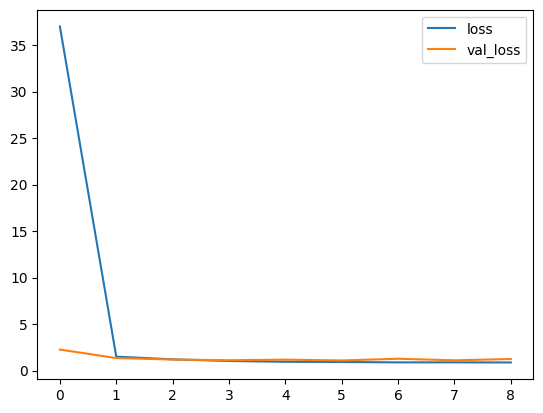

In [48]:
# Plot
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [50]:
print(X_treino_array.shape)


(16000, 5587)


In [51]:
print(X_teste_array.shape)


(2000, 1563)


In [91]:
# Predictions
previsoes_v1 = modelo_dsa_v1.predict(X_teste_array)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [92]:
# Extract labels
previsoes_v1_labels = previsoes_v1.argmax(axis = 1)

In [93]:
print(classification_report(y_teste_le, previsoes_v1_labels))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       275
           1       0.81      0.83      0.82       224
           2       0.87      0.91      0.89       695
           3       0.72      0.73      0.72       159
           4       0.89      0.88      0.89       581
           5       0.74      0.61      0.67        66

    accuracy                           0.85      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.85      0.85      0.85      2000



In [94]:
print(confusion_matrix(y_teste_le, previsoes_v1_labels))

[[224  11   7   4  29   0]
 [ 12 185  11   0   8   8]
 [  5   3 631  38  14   4]
 [  1   1  31 116   9   1]
 [ 13  15  36   4 512   1]
 [  1  14  10   0   1  40]]


In [95]:
print(accuracy_score(y_teste_le, previsoes_v1_labels))

0.854


In [96]:
# Save the model
modelo_dsa_v1.save('modelo_dsa_v1.keras')

Step 8: Deploy verson 1

In [98]:
# using the saved model
modelo_carregado = load_model('modelo_dsa_v1.keras')

In [99]:
frase = 'i even feel a little shaky'

In [100]:
# create a dataframe with the phrase
df_novo = pd.DataFrame({"Frase" : [frase]})


In [101]:
df_novo['Frase_Processada'] = df_novo['Frase'].apply(das_preprocessa_text)

In [102]:
df_novo

,Frase,Frase_Processada
0,i even feel a little shaky,feel little shaky


In [104]:
# Applying vetorization
df_novo_tfidf = dsa_tfidf.transform(df_novo['Frase_Processada'])

In [105]:
# Tranform to array 
df_novo_array = df_novo_tfidf.toarray()

In [106]:
# Predictions
previsoes = modelo_carregado.predict(df_novo_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [109]:
previsoes

array([[5.4509460e-04, 9.9794358e-01, 9.3151949e-04, 1.1080231e-06,
        7.0243419e-05, 5.0846284e-04]], dtype=float32)

In [107]:
# Selecting the highest probability class
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [108]:
classe_maior_prob

array([1])

In [110]:
# Get the class name
nome_classe = dsa_le.inverse_transform(classe_maior_prob)

In [111]:
nome_classe

array(['fear'], dtype=object)